# Neural network classification with PyTorch

Classification is a problem of predicting something is one thing or another (there can be multiple things as the options)

## Make classificcation data and get it ready





In [96]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [97]:
len(X), len(y)

(1000, 1000)

In [98]:
print(f'First 5 samples of X:\n {X[:5]}')
print(f'First 5 samples of y:\n {y[:5]}')

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [99]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({'X1': X[:, 0],
                        'X2': X[:, 1],
                        'label': y})

In [100]:
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [101]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

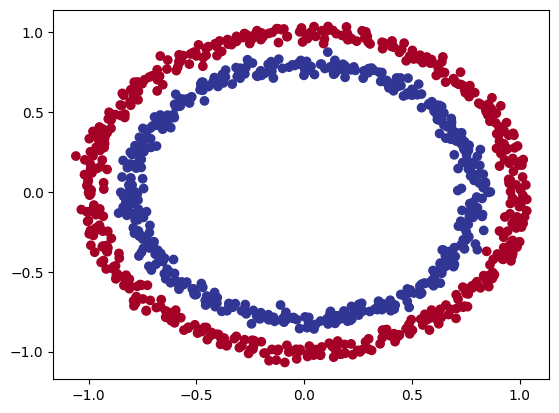

In [102]:
# Visualisation 
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)


**Note:** *The data we'ra working with is often referred to as a toy dataset, a dataset that is small enough to experiment on, but still sizable enough to practise the fundamentals.*

Toy datasets - https://scikit-learn.org/stable/datasets/toy_dataset.html

### Check input and output shapes

In [103]:
# Checking shapes
X.shape, y.shape

((1000, 2), (1000,))

In [104]:
# View the first examples of features and labels
X_sample = X[0]
y_sample = y[0]

print(f'Values for one samle of X: {X_sample} and the same for y: {y_sample}')
print(f'Values for one samle of X: {X_sample.shape} and the same for y: {y_sample.shape}') # Note: y is scalar

Values for one samle of X: [0.75424625 0.23148074] and the same for y: 1
Values for one samle of X: (2,) and the same for y: ()


### Turn data into tensors and create train and test splits

In [105]:
import torch

In [106]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [107]:
# Checking datatype
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

### Split data into training and test sets

`sklearn.model_selection.train_test_split(X, y, test_size, random_state)` - randomly splits a dataset into two subsets: a training set and a testing set.
* `test_size` - size of our test set for example `0.2` is `20%`
* `random_state` - random seed for example `42`

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split

In [108]:
## Split data into training and test sets 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [109]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Building a model 

We will build a model to clasify our blue and red dots.

To do so, we want to:
0. Imports necessary libraries.
1. Setup device agnostic code so our code will run on an GPU if there is one.
2. Construct a model (by subclassing `nn.Module`).
3. Define a loss function and optimizer.
4. Create a training and test loop.

In [110]:
# Import PyTorch and nn
import torch
from torch import nn

### 1. Setup device agnostic code

In [111]:
# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

if device == 'cuda': 
  !nvidia-smi

Using cuda
Sun Apr 16 08:44:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    36W /  70W |    821MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                             

### Building model

Our model:
1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`).
2. Create two `nn.Linear()` layers that are capable of handling the shapes of our data.
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the models.
4. Instantiate an instance of our model and send ti to the targer `device`


In [112]:
# Checking shape of X_train
X_train.shape

torch.Size([800, 2])

In [113]:
# 1. Create a model that subclasses `nn.Module`
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear() layers that are capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # tahes in 5 features from previous layer and outputs a siingle feature  (shhame shape as y)
    
  # 3. Define a forward() method that outlines the forward pass of the models.
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output


[Visualisation of our model!](https://playground.tensorflow.org/#activation=linear&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=5&seed=0.28468&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

In [114]:
# 4. Instantiate an instance of our model and send ti to the targer device
model_0 = CircleModel().to(device)
model_0

CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [115]:
# Checking device and on which device is model
device, next(model_0.parameters()).device

('cuda', device(type='cuda', index=0))

In [116]:
# Replicate the modlel above using `nn.Sequential()`
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [117]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.2245, -0.6720],
                      [ 0.5802,  0.5928],
                      [-0.1109, -0.0805],
                      [-0.2886, -0.6386],
                      [-0.6881,  0.2628]], device='cuda:0')),
             ('0.bias',
              tensor([-0.3882, -0.4546, -0.0552, -0.2355, -0.2288], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0144, -0.0949, -0.1540, -0.2141, -0.3640]], device='cuda:0')),
             ('1.bias', tensor([0.3750], device='cuda:0'))])

In [118]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Setup loss function and optimizer

`torch.nn.BCEWithLogitsLoss` - https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html?highlight=nn+bcewithlogitsloss#torch.nn.BCEWithLogitsLoss

In [119]:
# Setup loss function 
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

In [120]:
# Setup optimizer 
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [121]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## Training model

To train our model, we're going to need to build a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### Going from row logits -> predictions probabilities -> predictions labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into **predictions probabilities** by passing them to kind of activation function (e.g sigmoid for  binary classification and softmax for multiclas classification).

Then we can convert our model's **prediction probabilities** to **prediction labels** by either rounding them or taking the `argmax()`.

In [122]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]

y_logits

tensor([[0.4445],
        [0.5470],
        [0.3681],
        [0.4654],
        [0.6730]], device='cuda:0')

In [123]:
# Use the sigmoid activation function on our model  to turn them to prediction propabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6093],
        [0.6334],
        [0.5910],
        [0.6143],
        [0.6622]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:

* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [124]:
# Find the predicted labels 
y_preds = torch.round(y_pred_probs)

In [125]:
# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

In [126]:
# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([True, True, True, True, True], device='cuda:0')


In [127]:
# Get rid of extra dimension
y_preds.squeeze()  

tensor([1., 1., 1., 1., 1.], device='cuda:0')

### Building training and testing loop

In [128]:
# Set the manual seed
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put the data into device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building training and testing loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) 

  # 2. Calculate loss and accuracy 
  loss = loss_fn(y_logits, y_train) # Note: we passing y_logits not y_pred because `nn.BCEWithLogitsLoss` expects as imput raw logits
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Forward pass (gradient descent)
  optimizer.step()

  ### Testing 
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # Print out what's happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.73404, Acc: 50.00% | Test loss: 0.73405, Test acc: 50.00%
Epoch: 10 | Loss: 0.71263, Acc: 50.00% | Test loss: 0.71373, Test acc: 50.00%
Epoch: 20 | Loss: 0.70307, Acc: 50.00% | Test loss: 0.70452, Test acc: 50.00%
Epoch: 30 | Loss: 0.69864, Acc: 58.50% | Test loss: 0.70016, Test acc: 54.00%
Epoch: 40 | Loss: 0.69650, Acc: 53.00% | Test loss: 0.69801, Test acc: 53.00%
Epoch: 50 | Loss: 0.69540, Acc: 51.88% | Test loss: 0.69687, Test acc: 53.00%
Epoch: 60 | Loss: 0.69480, Acc: 51.75% | Test loss: 0.69622, Test acc: 50.50%
Epoch: 70 | Loss: 0.69443, Acc: 50.75% | Test loss: 0.69582, Test acc: 50.50%
Epoch: 80 | Loss: 0.69419, Acc: 50.62% | Test loss: 0.69556, Test acc: 50.50%
Epoch: 90 | Loss: 0.69401, Acc: 50.38% | Test loss: 0.69536, Test acc: 51.50%


## Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything.


So to inspect it let's make some predictions and make them visual!

To do so, we're going to import a function called `plot_decision_boundary()` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [129]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists, skipping download


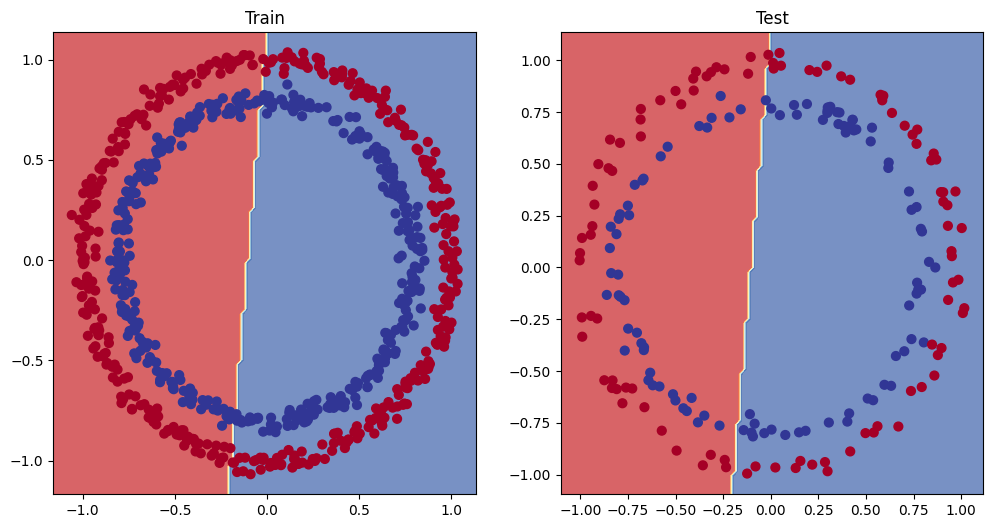

In [130]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred as hyperparameters.

Let's try and improve our model by:

* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [131]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

In [132]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [133]:
# Create loss function 
loss_fn = nn.BCEWithLogitsLoss()

In [134]:
# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [135]:
# Cteate a training and evaluation loop
# Set a random seed
torch.manual_seed(42)

# Set the epochs (more than previously)
epochs = 1000

# Put the data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss and accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
  
  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


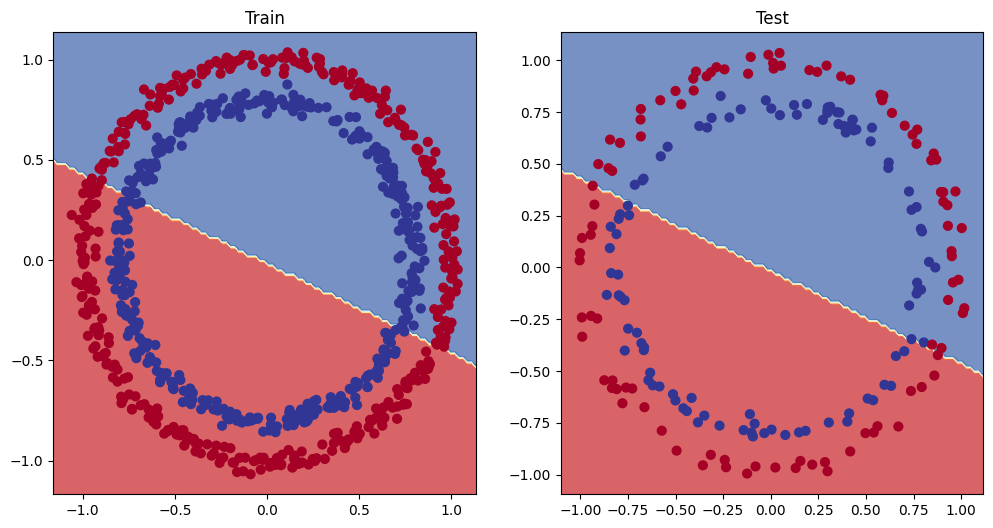

In [136]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### Preparing data to see if our model can fit a straight line

In [137]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01

# Create data 
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [138]:
from sklearn.utils.fixes import sklearn
# Crate train and test split
train_test_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_test_split], y_regression[:train_test_split]
X_test_regression, y_test_regression = X_regression[train_test_split:], y_regression[train_test_split:]

# Check the lenght of each
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

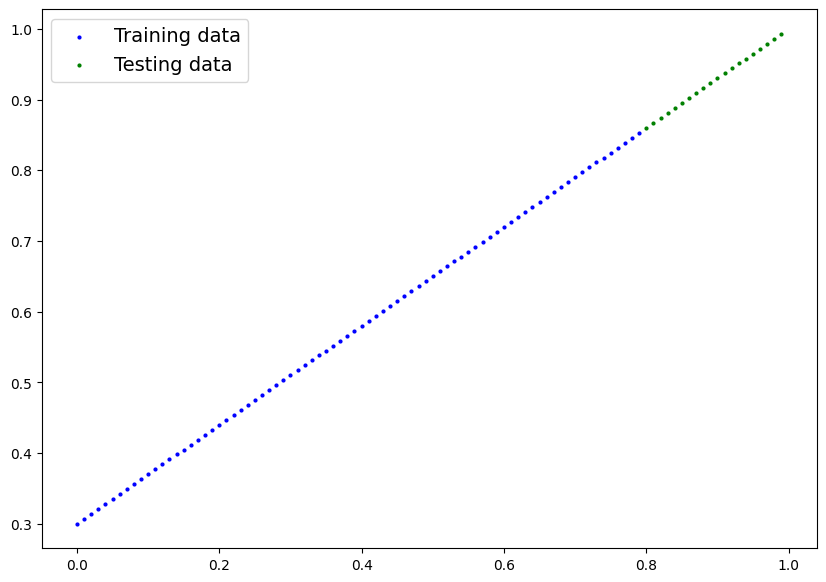

In [139]:
plot_predictions(train_data=X_train_regression, 
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression);

### Adjusting `model_1` to fit a straight line

In [140]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [141]:
# Loss function
loss_fn = nn.L1Loss() # MAE loss with regression data

In [142]:
# Optimizer
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [143]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")


Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


That is evidence that our `model_1` has capacity to learn.

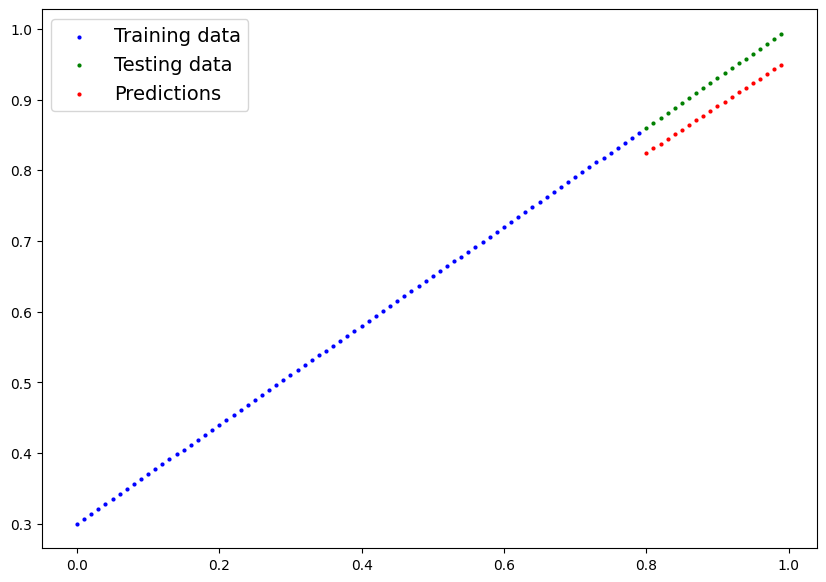

In [144]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(), 
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## The missing piece - **non-linearity**

"What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?

### Recreating non-linear data (red and blue circles)


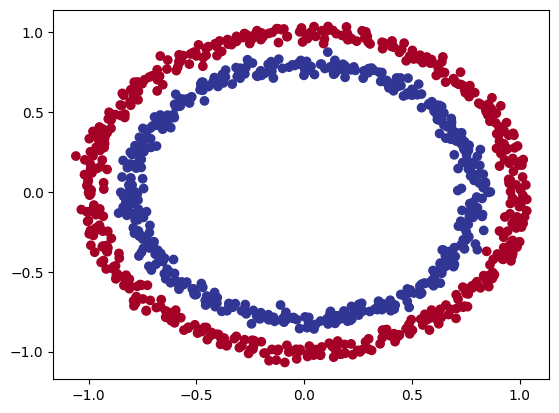

In [145]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [146]:
# Convert data to tensors and then to train and test splits 
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### Building a model with non-linearity

* Linear = straight lines
* Non-linear = non-straight lines

Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data.

* `torch.nn.ReLU` - Applies the rectified linear unit function element-wise *(takes inputs and if they're negative turns it to 0 and leaves the positive inputs how they are)*.
https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU


In [147]:
# Build a model with non-linear activation functions
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=64)
    self.layer_2 = nn.Linear(in_features=64, out_features=64)
    self.layer_3 = nn.Linear(in_features=64, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x):
    # Note: we are putting our activation function between layers
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [148]:
# Instantiate our model
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

### Training a model with non-linearity

In [149]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()

In [150]:
# Setup optimizer
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [151]:
# Random seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
  ### Training
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))  

  # 2. Calculate the loss and accuracy
  loss = loss_fn(y_logits, y_train) 
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    
    # 2. Calculate the loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
  
  # Print out what's this happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.6918, Acc: 47.38% | Test Loss: 0.6943, Test Acc: 46.50%
Epoch: 100 | Loss: 0.6797, Acc: 63.50% | Test Loss: 0.6850, Test Acc: 56.00%
Epoch: 200 | Loss: 0.6617, Acc: 78.00% | Test Loss: 0.6707, Test Acc: 71.00%
Epoch: 300 | Loss: 0.6231, Acc: 90.88% | Test Loss: 0.6372, Test Acc: 89.50%
Epoch: 400 | Loss: 0.5337, Acc: 99.00% | Test Loss: 0.5590, Test Acc: 98.00%
Epoch: 500 | Loss: 0.3749, Acc: 99.75% | Test Loss: 0.4144, Test Acc: 98.50%
Epoch: 600 | Loss: 0.2117, Acc: 100.00% | Test Loss: 0.2540, Test Acc: 99.50%
Epoch: 700 | Loss: 0.1263, Acc: 100.00% | Test Loss: 0.1637, Test Acc: 100.00%
Epoch: 800 | Loss: 0.0760, Acc: 100.00% | Test Loss: 0.1068, Test Acc: 100.00%
Epoch: 900 | Loss: 0.0512, Acc: 100.00% | Test Loss: 0.0777, Test Acc: 100.00%


### Evaluating a model trained with non-linear activation functions

In [152]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_pred[:10], y_test[:10]

(tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0.], device='cuda:0',
        grad_fn=<SliceBackward0>),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

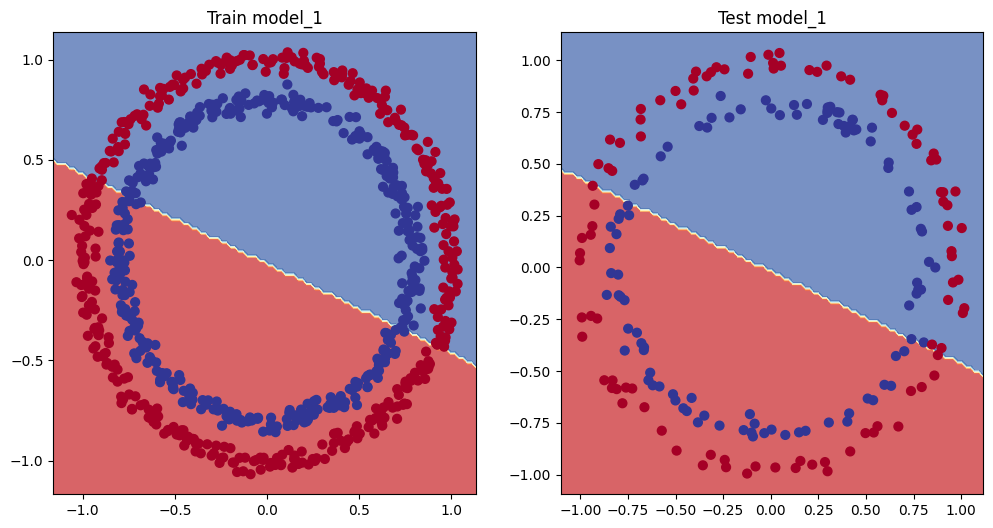

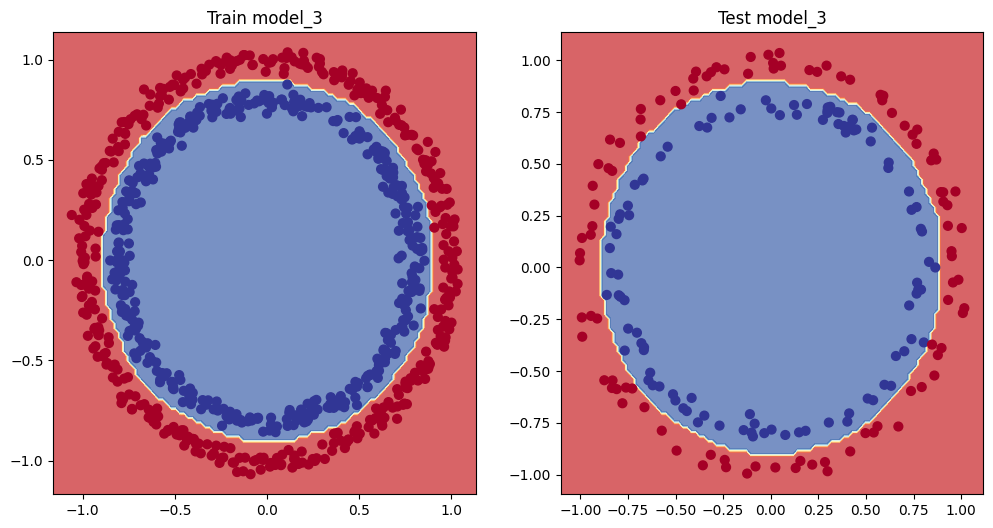

In [153]:
# Plot decision boundary of the model_1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train model_1")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test model_1")
plot_decision_boundary(model_1, X_test, y_test)

# Plot decision boundary of the model_3
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train model_3")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test model_3")
plot_decision_boundary(model_3, X_test, y_test)

## Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear & non-linear functions.

In [154]:
# Create tensor 
A = torch.arange(-10, 10, 1, dtype=torch.float32)

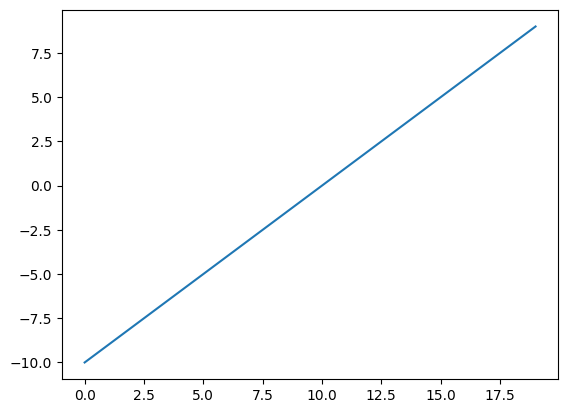

In [155]:
# Visualise the tensor
plt.plot(A)

In [156]:
# Recreating ReLu activation function
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) # input must be a tensor

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

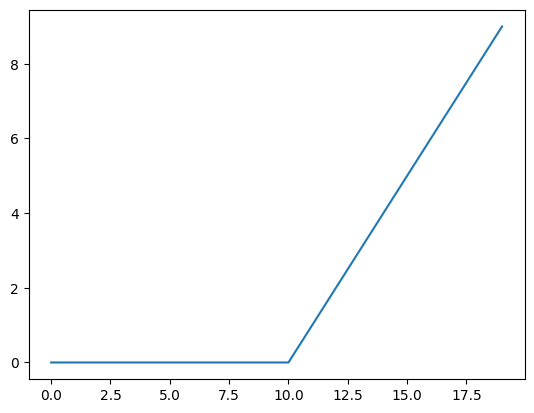

In [157]:
# Plot ReLu activation function
plt.plot(relu(A))

In [158]:
# Recreating Sigmoid activation function 
def sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1/ (1 + torch.exp(-x))

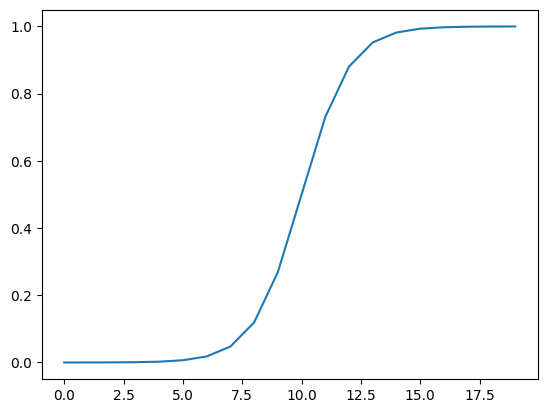

In [159]:
# Plot Sigmoid activation function
plt.plot(sigmoid(A))

## Putting all together with a multi-class classification problem 

* **Binary classification** - one thing on another (spam or not spam)
* **Multi-class classification** -  more than one thing on another (cat or dog or horse)

### Imports


In [160]:
# Imports
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

### Data

In [161]:
# set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [162]:
# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, 
                            random_state=RANDOM_SEED)

In [163]:
# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

In [164]:
# 3. Split into train and test splits
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)


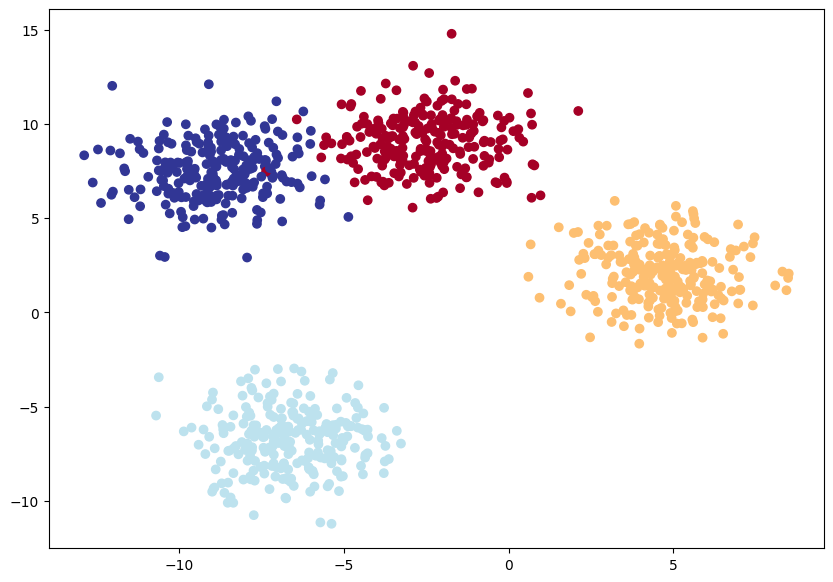

In [165]:
# 4. Plot the date
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### Building a multi-class classification model

In [166]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [167]:
# Building a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
    Initializes multi-class classification model.
    
    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )
  
  def forward(self, x):
    return self.linear_layer_stack(x)

In [168]:
# Create instance of BlobModel and send it to target device
model_4 = BlobModel(input_features=2, output_features=4)
model_4.to(device)


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### Create a loss function and optimizer for multi-class classification model

In [169]:
# Create loss function
loss_fn = nn.CrossEntropyLoss()

In [170]:
# Create optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

### Getting prediction propabilities for a multi-classs model

In order to evaluate and train and test our model, we need to convert our model's outputs (logtis) to predicition probabilities and then to prediction labels.

Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probabilities)

In [171]:
# Get logits 
model_4.eval()
with torch.inference_mode():
  y_blob_logits = model_4(X_test.to(device))

y_blob_logits[:10]

tensor([[ 0.2012, -0.3399,  0.0384, -0.0197],
        [ 0.1854, -0.3857, -0.0116, -0.0469],
        [ 0.2536, -0.2390,  0.1556,  0.0181],
        [ 0.1860, -0.3692,  0.0045, -0.0307],
        [ 0.2444, -0.2795,  0.1278, -0.0108],
        [ 0.2007, -0.2808,  0.0698, -0.0482],
        [ 0.0700, -0.3384, -0.1486, -0.2127],
        [ 0.0634, -0.3189, -0.1449, -0.2180],
        [ 0.2521, -0.2392,  0.1543,  0.0197],
        [ 0.1848, -0.3871, -0.0153, -0.0480]], device='cuda:0')

`torch.nn.Softmax()`- *applies the Softmax function to an n-dimensional input Tensor rescaling them so that the elements of the n-dimensional output Tensor lie in the range [0,1] and sum to 1.*

https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=torch+softmax#torch.nn.Softmax

In [172]:
# Convert our model's logits outputs to prediction probabilites 
y_pred_probs = torch.softmax(y_blob_logits, dim=1)
y_pred_probs[:10]

tensor([[0.3092, 0.1800, 0.2628, 0.2480],
        [0.3146, 0.1777, 0.2583, 0.2494],
        [0.3023, 0.1847, 0.2741, 0.2389],
        [0.3112, 0.1786, 0.2596, 0.2506],
        [0.3070, 0.1818, 0.2733, 0.2379],
        [0.3054, 0.1887, 0.2679, 0.2381],
        [0.3104, 0.2063, 0.2494, 0.2339],
        [0.3078, 0.2100, 0.2499, 0.2323],
        [0.3020, 0.1848, 0.2739, 0.2394],
        [0.3149, 0.1778, 0.2578, 0.2495]], device='cuda:0')

In [173]:
# Converting our model's predictions propabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

### Creating a training and evaluation loop

In [174]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs 
epochs = 1000

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  ### Training 
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)
    
  # Print out what's happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 1.1588, Acc: 40.38% | Test loss: 1.0755, Test acc: 48.00%
Epoch: 10 | Loss: 0.6448, Acc: 96.75% | Test loss: 0.6607, Test acc: 97.50%
Epoch: 20 | Loss: 0.4254, Acc: 98.50% | Test loss: 0.4307, Test acc: 100.00%
Epoch: 30 | Loss: 0.2529, Acc: 99.12% | Test loss: 0.2451, Test acc: 99.50%
Epoch: 40 | Loss: 0.1123, Acc: 99.25% | Test loss: 0.1023, Test acc: 99.50%
Epoch: 50 | Loss: 0.0663, Acc: 99.25% | Test loss: 0.0585, Test acc: 99.50%
Epoch: 60 | Loss: 0.0507, Acc: 99.25% | Test loss: 0.0429, Test acc: 99.50%
Epoch: 70 | Loss: 0.0430, Acc: 99.25% | Test loss: 0.0349, Test acc: 99.50%
Epoch: 80 | Loss: 0.0384, Acc: 99.25% | Test loss: 0.0299, Test acc: 99.50%
Epoch: 90 | Loss: 0.0352, Acc: 99.25% | Test loss: 0.0266, Test acc: 99.50%
Epoch: 100 | Loss: 0.0331, Acc: 99.25% | Test loss: 0.0243, Test acc: 99.50%
Epoch: 110 | Loss: 0.0316, Acc: 99.25% | Test loss: 0.0226, Test acc: 99.50%
Epoch: 120 | Loss: 0.0304, Acc: 99.25% | Test loss: 0.0213, Test acc: 99.50%
Epoch: 13

### Making and evaluating predictions with a multi-class model

In [175]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

In [176]:
# View first 10 logits 
y_logits[:10]

tensor([[ -2.3751,  10.9387, -10.2038, -11.3271],
        [ -2.1934,  -9.4839,  -6.3062,   5.2289],
        [ -4.9855,  -5.3790,   5.3840,  -4.3115],
        [ -3.0428,   8.1532,  -5.4971,  -6.6867],
        [  6.4903,  -2.8976, -12.3324,  -8.4675],
        [ -2.7724, -11.1928,  -7.4741,   6.3900],
        [ -4.3608,  -4.5814,   4.6890,  -3.5910],
        [  5.8017,  -6.8308,  -9.7351,  -4.1265],
        [ -6.3789,  -6.9228,   6.6638,  -5.5251],
        [  6.2822,  -5.5357, -10.3558,  -5.4748]], device='cuda:0')

In [177]:
# Converting logits to predictions
y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

In [178]:
# View first 10 predictions 
y_pred[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

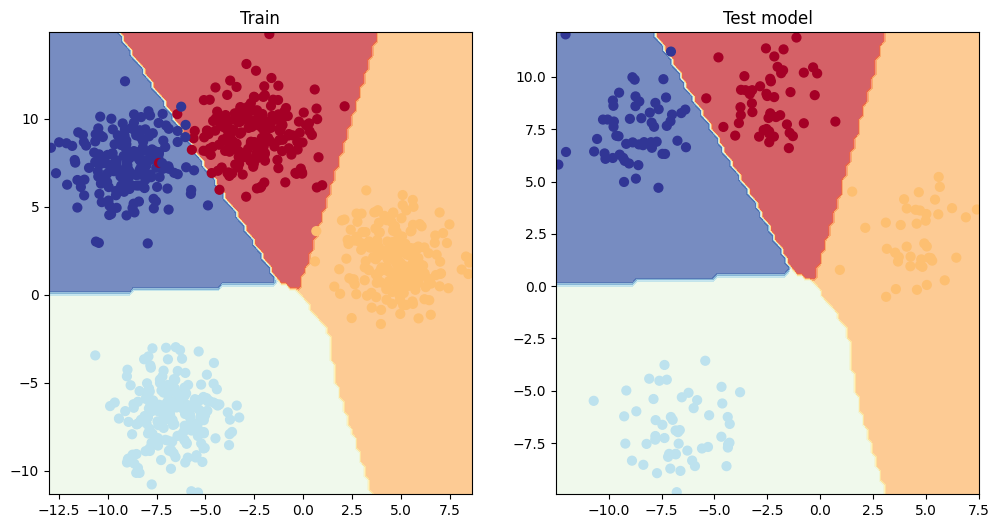

In [179]:
# Plot decision boundary of the model_4
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test model")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## A few more classification metrics (to evaluate our classification model)

* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

We can install and use TorchMetrics

See this article for when to use precision/recall - https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

If you want access to a lot of PyTorch metrics, see TorchMetrics - https://torchmetrics.readthedocs.io/en/latest/

